In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import cv2
from numba import jit
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as RMSE_dist
import gc

from importlib import reload
import hsilib as hl
hl = reload(hl)

In [5]:
def SID_dist(s1, s2):    
    s1 = s1 - s1.min() + 1
    s2 = s2 - s2.min() + 1

    p = s1 / np.sum(s1)
    q = s2 / np.sum(s2)    
    return np.sum((p - q) * (np.log(p) - np.log(q)))

def EVKLID_dist(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

def ANGLE_dist(vector1, vector2):
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)

    return np.dot(unit_vector1, unit_vector2)

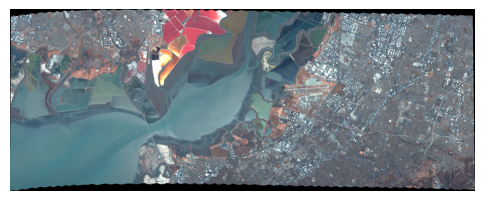

In [6]:
import spectral.io.envi as envi
hsi_path = r'C:\Users\konst\jupyter_notebook\HSI\data envil\moffet\\'
moffett_hsi = envi.open(hsi_path + r'f080611t01p00r07rdn_c_sc01_ort_img.hdr',
                        hsi_path + r'f080611t01p00r07rdn_c_sc01_ort_img')

HSI = np.array(np.rot90(moffett_hsi.open_memmap(writble = True)))

#HSI = HSI[..., :80]
height, width, bands = HSI.shape

color_image = hl.HSI_to_RGB(HSI, (37, 18, 11))
hl.show(color_image)

In [7]:
reference_coords = np.array(((540,  470),  #water
                             (288,  758),  #dirt
                             (154,  834),  #swamps
                             (315, 1334),  #soil
                             (335, 1360),  #vegetable
                             (305, 1280),  #concrete
                             (278,  606),  #salt
                             (18,   811),  #salt_water
                             (365, 1431)), #asphalt
                             dtype = int)

name_reference = ("water", "dirt", "swamps", "soil", "vegetable", "concrete", "salt", "salt_water", "asphalt")

colors_class = np.array(((0.56, 0.56, 1), (0.64, 0.28, 0.64), (0.05, 0.54, 0.13), (0.72, 0.45, 0.2),
                        (0, 0.9, 0), (0.29, 0.29, 0.29), (1, 1, 0), (1, 0, 0), (0, 0, 0)))

num_classes = reference_coords.shape[0]

win_size = 1
mrc = np.zeros(shape = (9, 4), dtype = int)
for r in range(reference_coords.shape[0]):
    mrc[r, 0] = reference_coords[r][0] - win_size     #y_up
    mrc[r, 1] = reference_coords[r][0] + win_size + 1 #y_dw
    mrc[r, 2] = reference_coords[r][1] - win_size     #x_lt
    mrc[r, 3] = reference_coords[r][1] + win_size + 1 #x_rt

In [8]:
#np.save("0-3", IMFs[0:4])
#np.save("4-7", IMFs[4:8])
#np.save("8-11", IMFs[8:12])
#np.save("12-15", IMFs[12:16])
#np.save("16-19", IMFs[16:20])

In [9]:
file_name = ("0-3.npy", "4-7.npy", "8-11.npy", "12-15.npy", "16-19.npy")
num_modes = 20

In [10]:
distance_metric = (EVKLID_dist, ANGLE_dist, SID_dist, RMSE_dist)
name_metric = ("EVKLID", "ANGLE", "SID", "RMSE")
num_metrics = len(distance_metric)

In [11]:
imfs = None

In [12]:
for i_m, metric in enumerate(distance_metric):
    
    corr_matrix = np.zeros(shape = (num_modes, num_classes, height, width), dtype = np.float32)
    
######################################################################
    for fi, fn in enumerate(file_name):
        if imfs is not None:
            del imfs
            _ = gc.collect()
        imfs = np.load(fn)
        for imf in range(imfs.shape[0]):
            n_mode = fi * 4 + imf
            print("\nglobal mode number: " + str(n_mode + 1))
######################################################################
    
            for classes in range(num_classes):
            
                reference = imfs[imf, mrc[classes, 0]:mrc[classes, 1], mrc[classes, 2]:mrc[classes, 3], :].mean(axis = (0, 1))
            
                for h in range(height):
                
                    for w in range(width):
                                
                        corr_matrix[n_mode, classes, h, w] = metric(reference, imfs[imf, h, w])
                
                    print("\r", end = "")
                    print("metric: " + name_metric[i_m] + "\t imf file: " + fn + "\t imf #: " + str(imf) + "\t clsess #: " + str(classes) + "\t height: " + str(h), end = "")
                    
                    
    np.save("corr-matrix-20-imfs-9-ref-" + name_metric[i_m], corr_matrix)


global mode number: 1
metric: EVKLID	 imf file: 0-3.npy	 imf #: 0	 clsess #: 8	 height: 752
global mode number: 2
metric: EVKLID	 imf file: 0-3.npy	 imf #: 1	 clsess #: 8	 height: 752
global mode number: 3
metric: EVKLID	 imf file: 0-3.npy	 imf #: 2	 clsess #: 8	 height: 752
global mode number: 4
metric: EVKLID	 imf file: 0-3.npy	 imf #: 3	 clsess #: 8	 height: 752
global mode number: 5
metric: EVKLID	 imf file: 4-7.npy	 imf #: 0	 clsess #: 8	 height: 752
global mode number: 6
metric: EVKLID	 imf file: 4-7.npy	 imf #: 1	 clsess #: 8	 height: 752
global mode number: 7
metric: EVKLID	 imf file: 4-7.npy	 imf #: 2	 clsess #: 8	 height: 752
global mode number: 8
metric: EVKLID	 imf file: 4-7.npy	 imf #: 3	 clsess #: 8	 height: 752
global mode number: 9
metric: EVKLID	 imf file: 8-11.npy	 imf #: 0	 clsess #: 8	 height: 752
global mode number: 10
metric: EVKLID	 imf file: 8-11.npy	 imf #: 1	 clsess #: 8	 height: 752
global mode number: 11
metric: EVKLID	 imf file: 8-11.npy	 imf #: 2	 clsess 

C:\Users\konst\AppData\Local\Temp\ipykernel_12324\2615532171.py:14: RuntimeWarning: invalid value encountered in divide
  unit_vector2 = vector2 / np.linalg.norm(vector2)


metric: ANGLE	 imf file: 0-3.npy	 imf #: 0	 clsess #: 8	 height: 752
global mode number: 2
metric: ANGLE	 imf file: 0-3.npy	 imf #: 1	 clsess #: 8	 height: 752
global mode number: 3
metric: ANGLE	 imf file: 0-3.npy	 imf #: 2	 clsess #: 8	 height: 752
global mode number: 4
metric: ANGLE	 imf file: 0-3.npy	 imf #: 3	 clsess #: 8	 height: 752
global mode number: 5
metric: ANGLE	 imf file: 4-7.npy	 imf #: 0	 clsess #: 8	 height: 752
global mode number: 6
metric: ANGLE	 imf file: 4-7.npy	 imf #: 1	 clsess #: 8	 height: 752
global mode number: 7
metric: ANGLE	 imf file: 4-7.npy	 imf #: 2	 clsess #: 8	 height: 752
global mode number: 8
metric: ANGLE	 imf file: 4-7.npy	 imf #: 3	 clsess #: 8	 height: 752
global mode number: 9
metric: ANGLE	 imf file: 8-11.npy	 imf #: 0	 clsess #: 8	 height: 752
global mode number: 10
metric: ANGLE	 imf file: 8-11.npy	 imf #: 1	 clsess #: 8	 height: 752
global mode number: 11
metric: ANGLE	 imf file: 8-11.npy	 imf #: 2	 clsess #: 8	 height: 752
global mode numb

KeyboardInterrupt: 